In [1]:
f = "1903.json"
# use multiline because each json record is split into many lines as can be seen in notepad++
df = spark.read.format("json").option("multiLine", True).option("header" , "true").option("inferSchema", "true").load(f)



In [2]:
df.printSchema()

root
 |-- Result: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- developer: string (nullable = true)
 |    |    |-- developerSales: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- highestPrice: long (nullable = true)
 |    |    |    |    |-- launchedInMonth: long (nullable = true)
 |    |    |    |    |-- launchedToDate: long (nullable = true)
 |    |    |    |    |-- lowestPrice: long (nullable = true)
 |    |    |    |    |-- medianPrice: long (nullable = true)
 |    |    |    |    |-- refPeriod: string (nullable = true)
 |    |    |    |    |-- soldInMonth: long (nullable = true)
 |    |    |    |    |-- soldToDate: long (nullable = true)
 |    |    |    |    |-- unitsAvail: long (nullable = true)
 |    |    |-- district: string (nullable = true)
 |    |    |-- marketSegment: string (nullable = true)
 |    |    |-- project: string (nullable = true)
 |    |    |-- propertyType: string (

In [3]:
# Now we want to explode 2 times to enter into developerSales so later we get the dataframe at developerSales level
from pyspark.sql.functions import explode

df2 = df.select(explode(df.Result).alias("R"))
df2.printSchema()



root
 |-- R: struct (nullable = true)
 |    |-- developer: string (nullable = true)
 |    |-- developerSales: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- highestPrice: long (nullable = true)
 |    |    |    |-- launchedInMonth: long (nullable = true)
 |    |    |    |-- launchedToDate: long (nullable = true)
 |    |    |    |-- lowestPrice: long (nullable = true)
 |    |    |    |-- medianPrice: long (nullable = true)
 |    |    |    |-- refPeriod: string (nullable = true)
 |    |    |    |-- soldInMonth: long (nullable = true)
 |    |    |    |-- soldToDate: long (nullable = true)
 |    |    |    |-- unitsAvail: long (nullable = true)
 |    |-- district: string (nullable = true)
 |    |-- marketSegment: string (nullable = true)
 |    |-- project: string (nullable = true)
 |    |-- propertyType: string (nullable = true)
 |    |-- street: string (nullable = true)
 |    |-- x: string (nullable = true)
 |    |-- y: string (nullable = tr

In [4]:
# this is end explosion to enter into developer sales.
# cannot just do 1 explosion of df.Result.developerSales, because it will endup as struct is array
df3= df2.select(explode(df2.R.developerSales).alias("developerSales"))
df3.printSchema()
df4 = df3.select(df3.developerSales.launchedToDate.alias("NumUnitsLaunchedToDate"), \
                 df3.developerSales.soldToDate.alias("NumUnitsSoldToDate"))
df4.show()

root
 |-- developerSales: struct (nullable = true)
 |    |-- highestPrice: long (nullable = true)
 |    |-- launchedInMonth: long (nullable = true)
 |    |-- launchedToDate: long (nullable = true)
 |    |-- lowestPrice: long (nullable = true)
 |    |-- medianPrice: long (nullable = true)
 |    |-- refPeriod: string (nullable = true)
 |    |-- soldInMonth: long (nullable = true)
 |    |-- soldToDate: long (nullable = true)
 |    |-- unitsAvail: long (nullable = true)

+----------------------+------------------+
|NumUnitsLaunchedToDate|NumUnitsSoldToDate|
+----------------------+------------------+
|                    19|                 9|
|                   720|               699|
|                   200|                77|
|                   505|               505|
|                     0|                 0|
|                   110|                 4|
|                     0|                 0|
|                   841|               738|
|                   400|               318|


In [5]:
# calculate PercentageSold
import pyspark.sql.functions as func
df5 = df4.withColumn("PercentageSold",(df4["NumUnitsSoldToDate"]/df4["NumUnitsLaunchedToDate"])*100)
# round 'PercentageSold' in a new column:
# https://stackoverflow.com/questions/47046827/trouble-with-pyspark-round-function
df5 = df5.withColumn("PercentageSold", func.round(df5["PercentageSold"], 2))

df5.show()

+----------------------+------------------+--------------+
|NumUnitsLaunchedToDate|NumUnitsSoldToDate|PercentageSold|
+----------------------+------------------+--------------+
|                    19|                 9|         47.37|
|                   720|               699|         97.08|
|                   200|                77|          38.5|
|                   505|               505|         100.0|
|                     0|                 0|          null|
|                   110|                 4|          3.64|
|                     0|                 0|          null|
|                   841|               738|         87.75|
|                   400|               318|          79.5|
|                   345|               316|         91.59|
|                    12|                 5|         41.67|
|                   660|               657|         99.55|
|                   504|               503|          99.8|
|                     0|                 0|          nul

In [6]:
# add a key to this table because this table is made from the json exploded 2 levels, but other
# values we draw like Project and District are exploded 1 level in, so there is no connection

from pyspark.sql.functions import monotonically_increasing_id
df6 = df5.select("*").withColumn("id", monotonically_increasing_id())
df6.show()
df6.count()

+----------------------+------------------+--------------+---+
|NumUnitsLaunchedToDate|NumUnitsSoldToDate|PercentageSold| id|
+----------------------+------------------+--------------+---+
|                    19|                 9|         47.37|  0|
|                   720|               699|         97.08|  1|
|                   200|                77|          38.5|  2|
|                   505|               505|         100.0|  3|
|                     0|                 0|          null|  4|
|                   110|                 4|          3.64|  5|
|                     0|                 0|          null|  6|
|                   841|               738|         87.75|  7|
|                   400|               318|          79.5|  8|
|                   345|               316|         91.59|  9|
|                    12|                 5|         41.67| 10|
|                   660|               657|         99.55| 11|
|                   504|               503|          99

131

In [7]:
# now explode only the layer of "Result", which is df2 above
df7 = df2.select(df2.R.project.alias("Project"),df2.R.district.alias("District"), df2.R.street.alias("Street"))
df8 = df7.select("*").withColumn("id", monotonically_increasing_id())
df8.show()
df8.count()

+--------------------+--------+--------------------+---+
|             Project|District|              Street| id|
+--------------------+--------+--------------------+---+
|   CAYMAN RESIDENCES|      15|   EAST COAST AVENUE|  0|
|GRANDEUR PARK RES...|      16|BEDOK SOUTH AVENUE 3|  1|
|THE FLORENCE RESI...|      19|    HOUGANG AVENUE 2|  2|
|  THE CLEMENT CANOPY|      05|   CLEMENTI AVENUE 1|  3|
|COASTLINE RESIDENCES|      15|          AMBER ROAD|  4|
|             REZI 24|      14|   LORONG 24 GEYLANG|  5|
|THE GREEN COLLECTION|      04|          COVE DRIVE|  6|
|  SEASIDE RESIDENCES|      15|         SIGLAP LINK|  7|
|               ARTRA|      03|      ALEXANDRA VIEW|  8|
|       MARTIN MODERN|      09|        MARTIN PLACE|  9|
|          HILLSGROVE|      19|      HILLSIDE DRIVE| 10|
|      DUO RESIDENCES|      07|       FRASER STREET| 11|
|      TREASURE CREST|      19| ANCHORVALE CRESCENT| 12|
|     ROOTS @ TRANSIT|      26|        TRANSIT ROAD| 13|
|             REZI 35|      14|

131

In [8]:
# joining df6 and df8 by the id key
df_final = df6.join(df8, df8["id"] == df6["id"])
df_final= df_final.select("Project","PercentageSold","NumUnitsLaunchedToDate",
                          "NumUnitsSoldToDate","District","Street")

df_final.printSchema()

root
 |-- Project: string (nullable = true)
 |-- PercentageSold: double (nullable = true)
 |-- NumUnitsLaunchedToDate: long (nullable = true)
 |-- NumUnitsSoldToDate: long (nullable = true)
 |-- District: string (nullable = true)
 |-- Street: string (nullable = true)



In [9]:
# cast the datatype according to the specs
df_final = df_final.withColumn("NumUnitsLaunchedToDate", df_final['NumUnitsLaunchedToDate'].cast("int"))
df_final = df_final.withColumn("NumUnitsSoldToDate", df_final['NumUnitsSoldToDate'].cast("int"))
df_final = df_final.withColumn("District", df_final['District'].cast("int"))
df_final.printSchema()

root
 |-- Project: string (nullable = true)
 |-- PercentageSold: double (nullable = true)
 |-- NumUnitsLaunchedToDate: integer (nullable = true)
 |-- NumUnitsSoldToDate: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Street: string (nullable = true)



In [10]:
# Run SQL queries on Dataframe: filter top 20
# Register the DataFrame as a SQL temporary view
df_final.createOrReplaceTempView("privateProperties")

sqlDF = spark.sql("SELECT * FROM privateProperties \
WHERE percentageSold IS NOT NULL")
sqlDF.show()


+--------------------+--------------+----------------------+------------------+--------+--------------------+
|             Project|PercentageSold|NumUnitsLaunchedToDate|NumUnitsSoldToDate|District|              Street|
+--------------------+--------------+----------------------+------------------+--------+--------------------+
|   CAYMAN RESIDENCES|         47.37|                    19|                 9|      15|   EAST COAST AVENUE|
|GRANDEUR PARK RES...|         97.08|                   720|               699|      16|BEDOK SOUTH AVENUE 3|
|THE FLORENCE RESI...|          38.5|                   200|                77|      19|    HOUGANG AVENUE 2|
|  THE CLEMENT CANOPY|         100.0|                   505|               505|       5|   CLEMENTI AVENUE 1|
|             REZI 24|          3.64|                   110|                 4|      14|   LORONG 24 GEYLANG|
|  SEASIDE RESIDENCES|         87.75|                   841|               738|      15|         SIGLAP LINK|
|         

In [11]:
# save the final dataframe
sqlDF.repartition(1).write.format("csv").option("header","true").mode("overwrite").save("NoLimit_Unsold_PrivateProperties.csv")


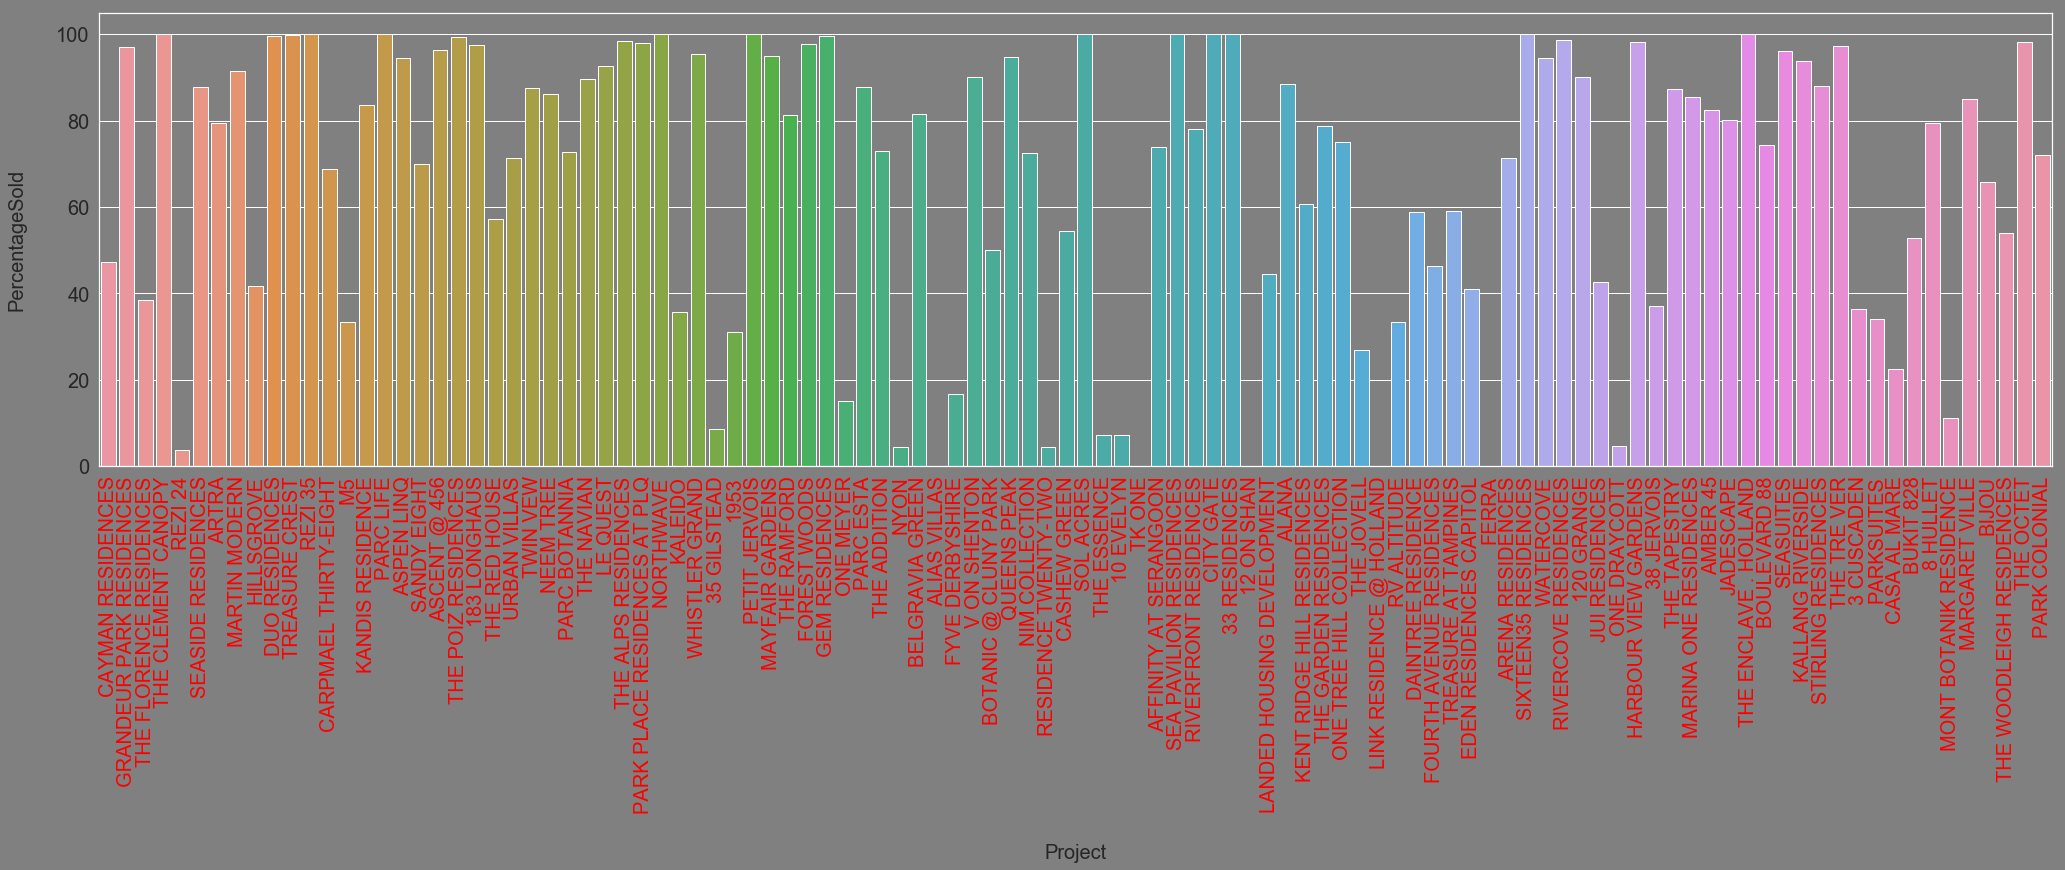

In [12]:
# time to draw the bargraph
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor':'#808080', 'figure.facecolor':'#808080'})

df_final_pandas = sqlDF.toPandas()
fig = plt.figure(figsize=(35,35))
fig.subplots_adjust(bottom=0.7)
ax = sns.barplot(x="Project", y="PercentageSold", data=df_final_pandas)
#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'cornflowerblue'})



plt.xlabel('Project', size = 20,labelpad=30)
plt.ylabel('PercentageSold', size = 20, labelpad=30)
plt.xticks(fontsize=20,rotation=90, color='red')
plt.yticks(fontsize=20)
#plt.title('SOR Rates', fontdict = {'fontsize' : 30})
#print(df_final_pandas)
fig.savefig("NoLimit_unsold_private_Properties.png")
#fig.show()

In [13]:
df2.printSchema()

root
 |-- R: struct (nullable = true)
 |    |-- developer: string (nullable = true)
 |    |-- developerSales: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- highestPrice: long (nullable = true)
 |    |    |    |-- launchedInMonth: long (nullable = true)
 |    |    |    |-- launchedToDate: long (nullable = true)
 |    |    |    |-- lowestPrice: long (nullable = true)
 |    |    |    |-- medianPrice: long (nullable = true)
 |    |    |    |-- refPeriod: string (nullable = true)
 |    |    |    |-- soldInMonth: long (nullable = true)
 |    |    |    |-- soldToDate: long (nullable = true)
 |    |    |    |-- unitsAvail: long (nullable = true)
 |    |-- district: string (nullable = true)
 |    |-- marketSegment: string (nullable = true)
 |    |-- project: string (nullable = true)
 |    |-- propertyType: string (nullable = true)
 |    |-- street: string (nullable = true)
 |    |-- x: string (nullable = true)
 |    |-- y: string (nullable = tr